# Modelling Heterogeneous Expectations

### Pau Belda, June 2021

In this note, I show how a standard asset pricing model with subjective and heterogeneous expectations can replicate some important the empirical facts.

The strategy is as follows: 
- Use Adam, Marcet and Beutel (2017) model, which replicates market volatility + half of the equity premium. 
- Extend it, if needed, to replicate additional moments involving disagreement (from Adrian's empirical analysis + Vanguard's paper).  

<br>

For now, I'm focusing on two facts from survey expectations:

1.- The dominance of individual effects (systematic gap between agents expectations; the most optimistic tend  to remain always there).

2.- The disagreement is higher at the top of the cycle. 


## Model Structure
As a baseline, consider the model used by Adam, Marcet and Beutel (2017).
<br>
The investor's problem can be written as (normalized by dividends, to get stationary ratios):
\begin{equation}
      \max_{\substack{\{C_t^i, S_t^i\}_{t=0}^\infty}} \mathbb{E}_0^{\mathcal{P}_i} \sum_{t=0}^\infty \delta^t \frac{D_t^{1-\gamma}}{1-\gamma} \Bigg(\frac{C_t^i}{D_t}\Bigg)^{1-\gamma}
\end{equation}
s.t. 

\begin{equation}
    \frac{C_t^i}{D_t} + \frac{P_t}{D_t}S_t^i = \Bigg(\frac{P_t}{D_t} + 1 \Bigg)S_{t-1}^i + \frac{W_t}{D_t}
\end{equation}

<br>

\begin{equation}
   \underline{S} \leq S_t^i \leq \bar{S}
\end{equation}
Lower bound: rules out Ponzi schemes; upper bound: aggregate stock supply (equal to the number of agents in the economy). They two ensure a compact feasible set.
<br>
<br>


**Exogenous resource processes**
<br>
1.- Dividends
\begin{equation}
 ln D_t = ln a + ln D_{t-1} + ln \varepsilon_t^D
\end{equation}
<br>

2.- Wage-dividend ratio
\begin{equation}
  ln \Big(1 + \frac{W_t}{D_t}\Big) =  (1-p)ln(1 + \rho) + p ln\Big(1 + \frac{W_{t-1}}{D_{t-1}}\Big) + ln \varepsilon_t^W
\end{equation}
The ln-innovations being jointly Normal, with covariance $\sigma_{DW}$.



**Information system**
<br>
Agents know the processes for dividends and wage-dividends. However, they ignore the exact way these fundamentals map into prices (which are exogenous to them, i.e. they are price-takers). 
<br>
Investors view prices as evolving according to this process

\begin{equation}
 ln P_t = ln b_{t}^i + ln P_{t-1} + ln \varepsilon_t^{P,i}
\end{equation}

with the permanent price growth $b_t$ being a drift that vary slowly over time

\begin{equation}
 ln b_{t}^i = ln b_{t-1}^i + ln \nu_t
\end{equation}

and the noisy price component being splitted into two independent components:

\begin{equation}
ln \varepsilon_t^{P,i} = ln \varepsilon_t^{P1,i} + ln \varepsilon_t^{P2,i} 
\end{equation}

The innovations $ln\varepsilon_t^P$ and $ln \nu_t$ being jointly Normal, but uncorrelated. 
<br>

The permanent price growth component $b_t$ is unobserved. It is estimated from the price signals that arises each period via the Kalman filter. Thus, the posterior beliefs are given by

\begin{equation}
   ln b_t^i \sim \mathcal{N} (ln \beta_t^i, \sigma^2)
\end{equation}

where $\sigma^2$ is the steady state variance of the posterior and $\beta_t^i$ is the conditional mean. It is assumed that $ ln \varepsilon_t^{P1,i}$ is observed at t. In this case, the optimal updating equation reads as
<br>

\begin{equation}
 ln \beta_t^i = ln \beta_{t-1}^i + g^i (ln P_{t-1} - ln P_{t-2} - ln \beta_{t-1}^i) + g^i ln \varepsilon_t^{P1,i}
\end{equation}


**Source of beliefs heterogeneity**
<br>
It is assumed that agents attach different weights to the new information that comes up; some are more conservative, some more sensitive to the latest news. In other words, they extrapolate past prices with different intensities, exhibiting different $g^i$. This learning heterogeneity is backed by survey evidence. 

Besides, investors can observe potentially different signals of transitory prices. If they behave optimally, they will incorporate these signals into their expectations, which will then differ further. 
<br>
<br>



## Step 1: Estimate gains from survey data
- Survey: Gallup UBS.
- Monthly frequency. 
- Time length: 1999.2 - 2007.10
- Build expectations groups/cohorts, that can be tracked over time. I've used 3 groups.
- To be consistent with the model, transform nominal return expectations into real capital gains expectations as follows:

1.- Deflate return expectations using Michigan's inflation expectations. 

2.- Substract mean dividend growth over the contemporaneous PD ratio to recover real capital gains expectations: 

\begin{equation}
 \mathbb{E}_t^{\mathcal{P}}\Big[\frac{P_{t+1}}{P_t}\Big] = \mathbb{E}_t^{\mathcal{P}}\Big[\frac{P_{t+1} + D_{t+1}}{P_t}\Big] - \frac{a}{PD_t}
\end{equation}

where

\begin{equation}
a= \mathbb{E}_t^{\mathcal{P}}\Big[\frac{D_{t+1}}{D_t}\Big]
\end{equation}

which is fixed at its historical mean. 

3.- Since expectations are for a one-year return, they are converted into monthly frequency, to be consistent with the model ($(1 + Annual)^{1/12} - 1 = Monthly$). 

In [2]:
#-------------------  Packages 
import numpy as np
import pandas as pand
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import statsmodels.api as sm



#-------------------  Data
data=pand.read_excel('Hetero.xlsx',sheet_name='For python sentiment')
m1=data['G1r_m']
m2=data['G2r_m']
m3=data['G3r_m']
pg=data['pg']
N=len(pg)


def gain(g):
    
    g1=g[0]
    g2=g[1]
    g3=g[2]
    
    beta1=np.ones((N))*m1[0] #Initial condition from the survey 1999.2
    beta2=np.ones((N))*m2[0]
    beta3=np.ones((N))*m3[0]
    for t in range(1,N):
        beta1[t]=beta1[t-1] + g1*(pg[t]-beta1[t-1])
        beta2[t]=beta2[t-1] + g2*(pg[t]-beta2[t-1])
        beta3[t]=beta3[t-1] + g3*(pg[t]-beta3[t-1])

    
    errors1=np.zeros((N))
    errors2=np.zeros((N))
    errors3=np.zeros((N))
    
    for t in range(1,N):
        errors1[t]=m1[t]-beta1[t]
        errors2[t]=m2[t]-beta2[t]
        errors3[t]=m3[t]-beta3[t]
    
    ssr1=np.mean(errors1**2)
    ssr2=np.mean(errors2**2)
    ssr3=np.mean(errors3**2)
    
    return ssr1+ssr2+ssr3


g=np.asarray([0.01, 0.01, 0.01])
bunds=[(0,1),(0,1),(0,1)]
solution3=optimize.minimize(gain,g,bounds=bunds,tol=0.0000005)
print(solution3.x)

[0.01132143 0.00986592 0.00358224]


As observed, the estimated gain are decreasing in optimism. That is consistent with Adrian's result. 


## Step 2: Model simulation. 

### Version 1: No expectations shocks. 
Assume $ln \varepsilon_t^{P1,i}=0$. 

In [50]:
#--------------------------------------------
"""Parameters"""
N=10000 #Periods
delta=0.995 #Discount rate
s_d = 0.0167 #Std. deviation div. growth
s_w= 0.0197 #Std. deviation wage-dividend growth
s_w2=0.017
s_dw=0.000374 #Covariance(wage-dividend,dividend)
s_ww=0.003 #Covariance wages 2 agents
p=0.98 #Persistence wage-dividend process.
rhow=22 #1+rhow is the average consumption-dividend ratio. 
gamma = 2 #Risk aversion parameter
sigma_e=s_d #Std. deviation transitory component price growth
sigma_v=s_d/5 #Std. deviation unobserved permanent component price growth innovation 
Initial=1000

a=1.002
gain1=0.01132143
gain2=0.00986592
gain3=0.00358224
supply=30

rho=np.exp((gamma/2)*(pow(s_w,2)*(1+gamma) - (1-gamma)*pow(s_d,2)))*np.exp(-gamma*(1-gamma)*s_dw)   #E(e_d[t+1]^{1-gamma} e_w[t+1]^{-gamma})        
pi=np.exp(-gamma*(1-gamma)*pow(s_d,2)/2) #E(e_d[t+1]^{1-gamma})
landa=delta*pow(a,1-gamma)*rho 
beta_RE_d=pow(a,1-gamma)*rho 



#------------------------------------------------
"""Exogenous processes"""
np.random.seed(10) #Reproducible simulation


#Hetero wages.
#---- Dividends and wage-dividends shocks -----
mean, cov = [(-pow(s_d,2)/2), (-pow(s_w,2)/2), (-pow(s_w,2)/2),(-pow(s_w,2)/2)], [(s_d**2, s_dw, s_dw, s_dw), (s_dw, s_w**2, s_ww, s_ww),(s_dw, s_ww , s_w**2, s_ww),(s_dw, s_ww , s_ww, s_w**2)]
shocks = np.random.multivariate_normal(mean, cov, N)
e_d=np.exp(shocks[:,0])
e_w1=np.exp(shocks[:,1])
e_w2=np.exp(shocks[:,2])
e_w3=np.exp(shocks[:,3])


wd1=np.ones((N))
wd2=np.ones((N))
wd3=np.ones((N))
for t in range(1,N):
    wd1[t]=np.exp((1-p)*np.log(1+rhow) + p*np.log(wd1[t-1]) + np.log(e_w1[t]))
    wd2[t]=np.exp((1-p)*np.log(1+rhow) + p*np.log(wd2[t-1]) + np.log(e_w2[t]))
    wd3[t]=np.exp((1-p)*np.log(1+rhow) + p*np.log(wd3[t-1]) + np.log(e_w3[t]))

#Dividends
dg=np.ones((N))
for t in range(N):
    dg[t]=a*e_d[t]
    

    
    
#------------------------------------------

"""Simulation"""
chi=np.asarray([0.95027315, 0.9501313,  0.95018491]) #Estimated from PEA (I skip this estimation, just to save space.)

chi1=chi[0]
chi2=chi[1]
chi3=chi[2]

#Beliefs
beta1=np.zeros((N))
beta1[1]=m1[0]+1  #Initial condition from surveys. 
beta2=np.zeros((N))
beta2[1]=m2[0]+1
beta3=np.zeros((N))
beta3[1]=m3[0]+1
log_beta1=np.zeros((N))
log_beta2=np.zeros((N))
log_beta3=np.zeros((N))


#Propensity to consume out of wealth
B1=np.ones((N))
B2=np.ones((N))
B3=np.ones((N))

#Stocks 
s1=np.ones((N))*(supply/3)
s2=np.ones((N))*(supply/3)
s3=np.ones((N))*(supply/3)

#Consumption
c1=np.ones((N))
c2=np.ones((N))
c3=np.ones((N))
   

#Equilibrium prices
pd=np.ones((N))
pd[0]=30

#Price growth vector
pg=np.ones((N))

#Prediction error
prediction_error1=np.ones((N))
prediction_error2=np.ones((N))
prediction_error3=np.ones((N))

#Wealth
wealth1=np.ones((N))
wealth2=np.ones((N))
wealth3=np.ones((N))
  
beta_top=np.ones((N))
beta_middle=np.ones((N))
beta_bottom=np.ones((N))

wealth_top=np.ones((N))
wealth_middle=np.ones((N))
wealth_bottom=np.ones((N))


for t in range(1,N-1):    

    #Time-varying propensity to consume out of wealth
    B1[t]=1-chi1*beta1[t] 
    B2[t]=1-chi2*beta2[t] 
    B3[t]=1-chi3*beta3[t] 
       
    #Projection facility
    #Restrict beliefs to ensure positive prices (never used).
    if B1[t]<=0.01 or B1[t]>=1:
        B1[t]=B1[t-1]
        beta1[t]=beta1[t-1]
    
    if B2[t]<=0.01 or B2[t]>=1:
        B2[t]=B2[t-1]
        beta2[t]=beta2[t-1]
    
    if B3[t]<=0.01 or B3[t]>=1:
        B3[t]=B3[t-1]
        beta3[t]=beta3[t-1]
    
    #Equilibrium PD
    pd[t]=((1-B1[t])*(wd1[t]-1 + s1[t-1]) + (1-B2[t])*(wd2[t]-1 + s2[t-1]) + (1-B3[t])*(wd3[t]-1 + s3[t-1]))/(supply - (1-B1[t])*s1[t-1] - (1-B2[t])*s2[t-1] - (1-B3[t])*s3[t-1])
    
    #Price growth
    pg[t]=(pd[t]/pd[t-1])*dg[t]
    
    #Prediction error
    prediction_error1[t]= np.log((pg[t]))- np.log(beta1[t])
    prediction_error2[t]= np.log((pg[t]))- np.log(beta2[t])
    prediction_error3[t]= np.log((pg[t]))- np.log(beta3[t])
    
    #Beliefs updating
    log_beta1[t+1]=np.log(beta1[t]) + gain1*prediction_error1[t]
    log_beta2[t+1]=np.log(beta2[t]) + gain2*prediction_error2[t]
    log_beta3[t+1]=np.log(beta3[t]) + gain3*prediction_error3[t]
    
    beta1[t+1]=np.exp(log_beta1[t+1])
    beta2[t+1]=np.exp(log_beta2[t+1])
    beta3[t+1]=np.exp(log_beta3[t+1])
    
    
    #Effective stock
    s1[t]=((1-B1[t])*(wd1[t]-1 + (pd[t]+1)*s1[t-1]))/pd[t]
    s2[t]=((1-B2[t])*(wd2[t]-1 + (pd[t]+1)*s2[t-1]))/pd[t]
    s3[t]=((1-B3[t])*(wd3[t]-1 + (pd[t]+1)*s3[t-1]))/pd[t]
    
    #Consumption
    c1[t]=B1[t]*(wd1[t]-1 + (pd[t]+1)*s1[t-1])
    c2[t]=B2[t]*(wd2[t]-1 + (pd[t]+1)*s2[t-1])
    c3[t]=B3[t]*(wd3[t]-1 + (pd[t]+1)*s3[t-1])
    
    #Wealth
    wealth1[t]=(pd[t]+1)*s1[t-1]
    wealth2[t]=(pd[t]+1)*s2[t-1]
    wealth3[t]=(pd[t]+1)*s3[t-1]
       

    #-------------------------------
    #Sentiment groups
    betaa=[beta1[t],beta2[t],beta3[t]]
    beta_top[t]=max(betaa)
    beta_bottom[t]=min(betaa)
    arguments=[np.argmax(betaa), np.argmin(betaa)]
    possibilities=[0, 1, 2]
    third=np.in1d(possibilities,arguments)
    num=np.asarray(np.where(third==False))
    beta_middle[t]=betaa[int(num)]    
    
    #Wealth by sentiment groups
    weaalth=[wealth1[t], wealth2[t], wealth3[t]]
    wealth_top[t]=weaalth[np.argmax(betaa)]
    wealth_bottom[t]=weaalth[np.argmin(betaa)]
    wealth_middle[t]=weaalth[int(num)]

<ipython-input-50-cdf1749a0bcc>:38: RuntimeWarning: covariance is not positive-semidefinite.
  shocks = np.random.multivariate_normal(mean, cov, N)


Analyze the evolution of subjective expectations.

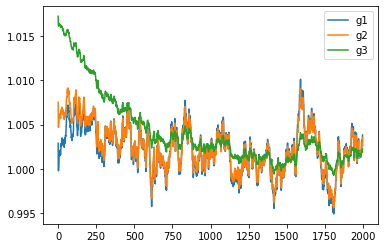

In [51]:
plt.plot(beta1[1:2000], label='g1')
plt.plot(beta2[1:2000],label='g2')
plt.plot(beta3[1:2000],label='g3')
plt.legend()

Lessons from the graph:
- The different initial condition only produce persistent groups for some periods. Note that this is true despite the huge initial gap. 
- Even in these initial periods, the more conservative guys from g3 hold a declining trend. That implies disagreement is decreasing, just because of this trend. 
- When the dependence of initial conditions weakens, the result is that sentiment groups do not correspond with individuals, as the following graph shows. 

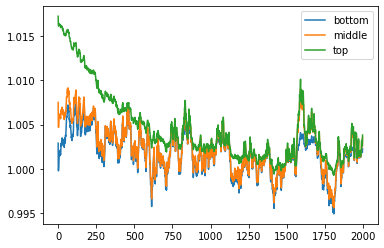

In [53]:
plt.plot(beta_bottom[1:2000], label='bottom')
plt.plot(beta_middle[1:2000],label='middle')
plt.plot(beta_top[1:2000],label='top')
plt.legend()

That would be evidence against the idea of sentiment groups. However, the Vanguard survey, aka the gold standard, shows that individual sentiment tend to be persistent. Hence, the problem seems that does not have to do with sentiment groups but with the way expectations are being modelled.  

A fact from Vanguard: individual features (wealth, age, gender, location, etc.) only explain a tiny fraction of expectations variation. In other words, it seems that there is something unknown, not linked to the common observables and idiosyncratic that explain the persistence in sentiment groups. An obvious way to model that is via idiosyncratic expectations shocks. In terms of the model, investors would get different transitory price signals that would make them systematically more optimistic or pessimistic. That could be a shortcut for asymmetric information, social capital, networks, etc. 

Simulate the model with idiosyncratic transitory price signals. 

In [47]:
""" 
Idiosyncratic transitory price shocks
"""

sigma_e3=0.0000005
sigma_e2=0.03
sigma_e1=0.03

mean, cov = [(-pow(sigma_e1,2)/2), (-pow(sigma_e2,2)/2), (-pow(sigma_e3,2)/2)], [(sigma_e3**2, 0, 0), (0, sigma_e3**2, 0),(0,0, sigma_e3**2)]
#mean, cov = [0.007, 0.007, 0.02], [(sigma_e1**2, 0, 0), (0, sigma_e2**2, 0),(0,0, sigma_e3**2)]
np.random.seed(10) #Reproducible simulation
shocks = np.random.multivariate_normal(mean, cov, N)
bel1=np.exp(shocks[:,0])
bel2=np.exp(shocks[:,1])
bel3=np.exp(shocks[:,2])


"""Simulation"""
chi=np.asarray([0.95027315, 0.9501313,  0.95018491]) #Estimated from PEA (I skip this estimation, just to save space.)

chi1=chi[0]
chi2=chi[1]
chi3=chi[2]

#Beliefs
beta1=np.zeros((N))
beta1[1]=m1[0]+1  #Initial condition from surveys. 
beta2=np.zeros((N))
beta2[1]=m2[0]+1
beta3=np.zeros((N))
beta3[1]=m3[0]+1
log_beta1=np.zeros((N))
log_beta2=np.zeros((N))
log_beta3=np.zeros((N))


#Propensity to consume out of wealth
B1=np.ones((N))
B2=np.ones((N))
B3=np.ones((N))

#Stocks 
s1=np.ones((N))*(supply/3)
s2=np.ones((N))*(supply/3)
s3=np.ones((N))*(supply/3)

#Consumption
c1=np.ones((N))
c2=np.ones((N))
c3=np.ones((N))
   

#Equilibrium prices
pd=np.ones((N))
pd[0]=30

#Price growth vector
pg=np.ones((N))

#Prediction error
prediction_error1=np.ones((N))
prediction_error2=np.ones((N))
prediction_error3=np.ones((N))

#Wealth
wealth1=np.ones((N))
wealth2=np.ones((N))
wealth3=np.ones((N))
  
beta_top=np.ones((N))
beta_middle=np.ones((N))
beta_bottom=np.ones((N))

wealth_top=np.ones((N))
wealth_middle=np.ones((N))
wealth_bottom=np.ones((N))

disagreement=np.ones((N))

for t in range(1,N-1):    

    #Time-varying propensity to consume out of wealth
    B1[t]=1-chi1*beta1[t] 
    B2[t]=1-chi2*beta2[t] 
    B3[t]=1-chi3*beta3[t] 
       
    #Projection facility
    #Restrict beliefs to ensure positive prices (never used).
    if B1[t]<=0.01 or B1[t]>=1:
        B1[t]=B1[t-1]
        beta1[t]=beta1[t-1]
    
    if B2[t]<=0.01 or B2[t]>=1:
        B2[t]=B2[t-1]
        beta2[t]=beta2[t-1]
    
    if B3[t]<=0.01 or B3[t]>=1:
        B3[t]=B3[t-1]
        beta3[t]=beta3[t-1]
    
    #Equilibrium PD
    pd[t]=((1-B1[t])*(wd1[t]-1 + s1[t-1]) + (1-B2[t])*(wd2[t]-1 + s2[t-1]) + (1-B3[t])*(wd3[t]-1 + s3[t-1]))/(supply - (1-B1[t])*s1[t-1] - (1-B2[t])*s2[t-1] - (1-B3[t])*s3[t-1])
    
    #Price growth
    pg[t]=(pd[t]/pd[t-1])*dg[t]
    
    #Prediction error
    prediction_error1[t]= np.log((pg[t]))- np.log(beta1[t])
    prediction_error2[t]= np.log((pg[t]))- np.log(beta2[t])
    prediction_error3[t]= np.log((pg[t]))- np.log(beta3[t])
    
    #Beliefs updating
    log_beta1[t+1]=np.log(beta1[t]) + gain1*prediction_error1[t]+ np.log(bel1[t])
    log_beta2[t+1]=np.log(beta2[t]) + gain2*prediction_error2[t]+ np.log(bel2[t])
    log_beta3[t+1]=np.log(beta3[t]) + gain3*prediction_error3[t]+ np.log(bel3[t])
    
    
    beta1[t+1]=np.exp(log_beta1[t+1])
    beta2[t+1]=np.exp(log_beta2[t+1])
    beta3[t+1]=np.exp(log_beta3[t+1])
    
    disagreement[t]=abs(beta1[t]-beta3[t])
    
    #Effective stock
    s1[t]=((1-B1[t])*(wd1[t]-1 + (pd[t]+1)*s1[t-1]))/pd[t]
    s2[t]=((1-B2[t])*(wd2[t]-1 + (pd[t]+1)*s2[t-1]))/pd[t]
    s3[t]=((1-B3[t])*(wd3[t]-1 + (pd[t]+1)*s3[t-1]))/pd[t]
    

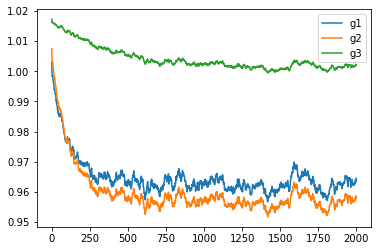

In [40]:
plt.plot(beta1[1:2000], label='g1')
plt.plot(beta2[1:2000],label='g2')
plt.plot(beta3[1:2000],label='g3')
plt.legend()

As observed, with idiosyncratic price signals, the dominance of individual fixed effects can be generated by the model. 


The second fact: correlation(disagreement,PD). It seems that the model has some problems with that. I have to think how to sort that out...

In [48]:
np.corrcoef(pd[1000:2000],disagreement[1000:2000])

array([[ 1.        , -0.55896149],
       [-0.55896149,  1.        ]])